In [1]:
# NLI(Natural Language Interference:자연어 추론) 훈련 예제
#
# => input_ids : [CLS]senetence1(전제)[SEP]sentence2(가설)
# => attention_mask : 1111111111(전체,가설)0000000(그외)
# => token_type_ids : 0000000(전제)1111111(가설)00000000(그외)
# => laels : 참(수반:entailment), 거짓(모순:contradiction), 모름(중립:neutral)

import numpy as np
import pandas as pd
import torch
import os
import torch.nn.functional as F

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, BertForSequenceClassification
import sys
sys.path.append("../../")
from myutils import seed_everything, GPU_info, mlogging
from tqdm.notebook import tqdm

logger = mlogging(loggername="distilbertfttrain", logfilename="../../../log/distilbertftmultitrain")
device = GPU_info()
# Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
os.environ["TOKENIZERS_PARALLELISM"] = "false"


logfilepath:../../../log/distilbertftmultitrain_2022-11-02.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30


In [2]:
#############################################################################################
# 변수들 설정
# - model_path : from_pretrained() 로 호출하는 경우에는 모델파일이 있는 폴더 경로나 
#          huggingface에 등록된 모델명(예:'bert-base-multilingual-cased')
#          torch.load(model)로 로딩하는 경우에는 모델 파일 풀 경로
#
# - vocab_path : from_pretrained() 호출하는 경우에는 모델파일이 있는 폴더 경로나
#          huggingface에 등록된 모델명(예:'bert-base-multilingual-cased')   
#          BertTokenizer() 로 호출하는 경우에는 vocab.txt 파일 풀 경로,
#
# - OUTPATH : 출력 모델, vocab 저장할 폴더 경로
#############################################################################################

##################################################
# 변수 설정
##################################################
seed = 111
epochs = 3            # epochs
lr = 3e-5  # 학습률
eps = 1e-8
max_seq_len = 72     # 글자 최대 토큰 길이 해당 토큰 길이 이상은 잘린다.
train_batch_size = 32      # 배치 사이즈(64면 GUP Memory 오류 나므로, 32 이하로 설정할것=>max_seq_length 를 줄이면, 64도 가능함)
eval_batch_size = 64
##################################################

seed_everything(seed) # seed 설정

cache = True   # 캐쉬파일 생성할거면 True로 (True이면 loding할때 캐쉬파일있어도 이용안함)

use_kornli = 1     #  kornli 파일
use_kluenli = 1    # kluests_v1.1 파일
use_gluenli = 1    # glue 파일

kor_train_file_fpath = '../../../data11/korpora/kornli/snli_1.0_train.ko.tsv'
kor_eval_file_fpath = '../../../data11/korpora/kornli/xnli.dev.ko.tsv'

klue_train_file_fpath = '../../../data11/korpora/klue-nli/klue-nli-v1.1_train.json'
klue_eval_file_fpath = '../../../data11/korpora/klue-nli/klue-nli-v1.1_dev.json'

glue_train_file_fpath = '../../../data11/korpora/gluemnli/glue-mnli-train.tsv'
glue_eval_file_fpath = '../../../data11/korpora/gluemnli/glue-mnli-valid.tsv'


# model 타입 : 0=distilbert, 1=bert, 2=Roberta, 3=Kobert
#=>Roberta 모델에는 distilbert처럼 token_type_id 입력 없음.
model_type = 0
model_path = 'bongsoo/mdistilbertV3.1' #  #distilbert-base-multilingual-cased #bert-re-kowiki-bert-mecab 
vocab_path = 'bongsoo/mdistilbertV3.1'
OUTPATH = '../../../data11/model/NLI/mdistilbertV3.1-nli'

# tokeniaer 및 model 설정
# strip_accents=False : True로 하면, 가자 => ㄱ ㅏ ㅈ ㅏ 식으로 토큰화 되어 버림(*따라서 한국어에서는 반드시 False)
# do_lower_case=False : # 소문자 입력 사용 안함(한국어에서는 반드시 False)
if model_type == 3:
    from kobert_tokenizer import KoBERTTokenizer
    tokenizer = KoBERTTokenizer.from_pretrained(model_path)
else:
    tokenizer = AutoTokenizer.from_pretrained(vocab_path, strip_accents=False, do_lower_case=False) 
                        
# NLI 모델에서 레벨은 3개지(참,거짓,모름) 이므로, num_labels=3을 입력함

if model_type == 0:
    model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=3)
elif model_type == 1 or model_type == 3:
    model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3)

# 레벨을 멀티로 선택해야 하는 경우
#model = BertForSequenceClassification.from_pretrained(model_path, problem_type="multi_label_classification",num_labels=6)
                   
#기존 모델 파일을 로딩하는 경우    
#model = torch.load(model_path) 

model.to(device)

Some weights of the model checkpoint at bongsoo/mdistilbertV3.1 were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at bongsoo/mdistilbertV3.1 and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(159552, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [3]:
model.num_parameters()

166050819

In [4]:
# 학습 data loader 생성
sys.path.append('..')
from myutils import ClassificationDataset, KorNLICorpus, KlueNLICorpus, GlueMNLICorpus, data_collator
from torch.utils.data import DataLoader, RandomSampler

train_dataset = []

# 훈련 NLI dataset 생성
if use_kornli == 1:
    corpus = KorNLICorpus()
    train_dataset += ClassificationDataset(file_fpath=kor_train_file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)

if use_kluenli == 1:
    corpus = KlueNLICorpus()
    train_dataset += ClassificationDataset(file_fpath=klue_train_file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)
    
if use_gluenli == 1:
    corpus = GlueMNLICorpus()
    train_dataset += ClassificationDataset(file_fpath=glue_train_file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)
    

# 훈련 dataloader 생성
train_loader = DataLoader(train_dataset, 
                          batch_size=train_batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(train_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          collate_fn=data_collator, # dataset을 tensor로 변환(예시 {'input_ids':tensor[0,1,2,3,1,], 'token_type_id:tensor[0,0,0,0,0], 'attention_mask:tensor[1,1,1,1,1], 'labels':tensor[5]}
                          num_workers=4)

# 평가 dataset 생성
eval_dataset = []

if use_kornli == 1:
    corpus = KorNLICorpus()
    eval_dataset += ClassificationDataset(file_fpath=kor_eval_file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)

if use_kluenli == 1:
    corpus = KlueNLICorpus()
    eval_dataset += ClassificationDataset(file_fpath=klue_eval_file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)
    
if use_gluenli == 1:
    corpus = GlueMNLICorpus()
    eval_dataset += ClassificationDataset(file_fpath=glue_eval_file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)

# 평가 dataloader 생성

    
eval_loader = DataLoader(eval_dataset, 
                          batch_size=eval_batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(eval_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          collate_fn=data_collator, # dataset을 tensor로 변환(예시 {'input_ids':tensor[0,1,2,3,1,], 'token_type_id:tensor[0,0,0,0,0], 'attention_mask:tensor[1,1,1,1,1], 'labels':tensor[5]}
                          num_workers=4)

print('train_loader_len: {}, eval_loader_len: {}'.format(len(train_loader), len(eval_loader)))

Creating features from dataset file at ../../../data11/korpora/kornli/snli_1.0_train.ko.tsv
loading data... LOOKING AT ../../../data11/korpora/kornli/snli_1.0_train.ko.tsv
tokenize sentences, it could take a lot of time...
tokenize sentences [took %.3f s] 45.168227672576904


  0%|          | 0/550151 [00:00<?, ?it/s]

*** Example ***
sentence A, B: 말을 탄 사람이 고장난 비행기 위로 뛰어오른다. + 한 사람이 식당에서 오믈렛을 주문하고 있다.
tokens: [CLS] 말 ##을 탄 사람이 고장 ##난 비행기 위로 뛰 ##어 ##오 ##른다 . [SEP] 한 사람이 식당 ##에서 [UNK] 주문 ##하고 있다 . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: contradiction
features: ClassificationFeatures(input_ids=[101, 9251, 10622, 9847, 97802, 123248, 33305, 122116, 121623, 9150, 12965, 28188, 66346, 119, 102, 9954, 97802, 123875, 11489, 100, 121399, 12453, 11506, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

  0%|          | 0/24998 [00:00<?, ?it/s]

*** Example ***
sentence A, B: 힛걸 진심 최고다 그 어떤 히어로보다 멋지다 + 힛걸 진심 최고로 멋지다.
tokens: [CLS] [UNK] 진심 최고 ##다 그 어떤 히어로 ##보다 멋 ##지 ##다 [SEP] [UNK] 진심 최고 ##로 멋 ##지 ##다 . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: entailment
features: ClassificationFeatures(input_ids=[101, 100, 128736, 83491, 11903, 8924, 55910, 128156, 80001, 9270, 12508, 11903, 102, 100, 128736, 83491, 11261, 9270, 12508, 11903, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

  0%|          | 0/392702 [00:00<?, ?it/s]

*** Example ***
sentence A, B: Conceptually cream skimming has two basic dimensions - product and geography. + Product and geography are what make cream skimming work. 
tokens: [CLS] Concept ##ually cream ski ##mming has two basic dimensions - product and ge ##ography . [SEP] Product and ge ##ography are what make cream ski ##mming work . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: neutral
features: ClassificationFeatures(input_ids=[101, 77961, 79090, 93461, 40122, 97469, 10393, 10551, 25090, 38590, 118, 21535, 10111, 46503, 34850, 119, 102, 93218, 10111, 46503, 34850, 10301, 12976, 13086, 93461, 40122, 97469, 11424, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1

  0%|          | 0/2490 [00:00<?, ?it/s]

*** Example ***
sentence A, B: 그리고 그가 말했다, "엄마, 저 왔어요." + 그는 학교 버스가 그를 내려주자마자 엄마에게 전화를 걸었다.
tokens: [CLS] 그리고 그가 말했다 , " 엄마 , 저 왔 ##어 ##요 . " [SEP] 그는 학교 버스 ##가 그를 내 ##려 ##주자 ##마 ##자 엄마 ##에게 전화 ##를 걸 ##었다 . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: neutral
features: ClassificationFeatures(input_ids=[101, 23289, 57790, 102055, 117, 107, 123845, 117, 9663, 9594, 12965, 48549, 119, 107, 102, 17889, 119811, 120214, 11287, 76203, 8996, 26737, 133626, 23811, 13764, 123845, 26212, 120846, 11513, 8867, 17706, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

  0%|          | 0/3000 [00:00<?, ?it/s]

*** Example ***
sentence A, B: 흡연자분들은 발코니가 있는 방이면 발코니에서 흡연이 가능합니다. + 어떤 방에서도 흡연은 금지됩니다.
tokens: [CLS] 흡연 ##자 ##분 ##들은 발코니 ##가 있는 방이 ##면 발코니 ##에서 흡연 ##이 가능 ##합 ##니다 . [SEP] 어떤 방 ##에서 ##도 흡연 ##은 [UNK] . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: contradiction
features: ClassificationFeatures(input_ids=[101, 129066, 13764, 37712, 22879, 142566, 11287, 13767, 135146, 14867, 142566, 11489, 129066, 10739, 119557, 33188, 48345, 119, 102, 55910, 9328, 11489, 12092, 129066, 10892, 100, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

  0%|          | 0/9815 [00:00<?, ?it/s]

*** Example ***
sentence A, B: The new rights are nice enough + Everyone really likes the newest benefits 
tokens: [CLS] The new rights are nice enough [SEP] Everyone really like ##s the new ##est benefits [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
label: neutral
features: ClassificationFeatures(input_ids=[101, 10117, 10751, 16691, 10301, 151987, 21408, 102, 157501, 30181, 11850, 10107, 10105, 10751, 13051, 48297, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [5]:
# tokenier 테스트
print(len(tokenizer))
print(tokenizer.encode("눈에 보이는 반전이었지만 영화의 흡인력은 사라지지 않았다", "정말 재미있다"))
print(tokenizer.convert_ids_to_tokens(131027))
print(tokenizer.convert_tokens_to_ids('정말'))

159552
[101, 9034, 10530, 124729, 11018, 125871, 10739, 69708, 42428, 10459, 10020, 121612, 10892, 133496, 12508, 49137, 102, 9670, 89523, 126553, 76820, 102]
명도
100


In [6]:
import time

logger.info(f"=== model: {model_path} ===")
logger.info(f"num_parameters: {model.num_parameters()}")

# 학습 시작

# optimizer 적용
optimizer = AdamW(model.parameters(), 
                 lr=lr, 
                 eps=eps) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs

num_warmup_steps = total_steps * 0.1
p_itr = int(total_steps * 0.1)           # 손실률 보여줄 step 수

# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1
total_loss = 0
total_len = 0
total_correct = 0
list_training_loss = []
list_acc_loss = []
list_validation_acc_loss = []

model.zero_grad()# 그래디언트 초기화
for epoch in tqdm(range(epochs)):

    model.train() # 훈련모드로 변환
    for data in tqdm(train_loader):
    
        #optimizer.zero_grad()
        model.zero_grad()# 그래디언트 초기화
        
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        if model_type == 1:
            token_type_ids = data['token_type_ids'].to(device) 
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)
        #print('Labels:{}'.format(labels))
        
        # 모델 실행
        if model_type == 0:
            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask,
                            labels=labels)
        else:
            outputs = model(input_ids=input_ids, 
                            token_type_ids=token_type_ids,
                            attention_mask=attention_mask,
                            labels=labels)
        
        # 출력값 loss,logits를 outputs에서 얻어옴
        loss = outputs.loss
        logits = outputs.logits
        #print('Loss:{}, logits:{}'.format(loss, logits))
        
        # optimizer 과 scheduler 업데이트 시킴
        loss.backward()   # backward 구함
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
        optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
        scheduler.step()  # 학습률 감소
        
        # 정확도와 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            # 정확도와 총 손실률 계산
            pred = torch.argmax(F.softmax(logits), dim=1)
            correct = pred.eq(labels)
            total_correct += correct.sum().item()
            total_len += len(labels)    
            total_loss += loss.item()
            #print('pred:{}, correct:{}'.format(pred, correct))

            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:

                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Train Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_correct/total_len))

                list_training_loss.append(total_loss/p_itr)
                list_acc_loss.append(total_correct/total_len)

                total_loss = 0
                total_len = 0
                total_correct = 0

        itr+=1
        
        #if itr > 5:
        #    break
   
    ####################################################################
    # 1epochs 마다 실제 test(validattion)데이터로 평가 해봄
    # 평가 시작
    
    start = time.time()
    logger.info(f'---------------------------------------------------------')

    model.eval()
    
    total_test_correct = 0
    total_test_len = 0
    
    for data in tqdm(eval_loader):
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        if model_type == 1:
            token_type_ids = data['token_type_ids'].to(device) 
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)
 
        # 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            # 모델 실행
              # 모델 실행
            if model_type == 0:
                outputs = model(input_ids=input_ids, 
                                attention_mask=attention_mask,
                                labels=labels)
            else:
                outputs = model(input_ids=input_ids, 
                                token_type_ids=token_type_ids,
                                attention_mask=attention_mask,
                                labels=labels)
    
            # 출력값 loss,logits를 outputs에서 얻어옴
            #loss = outputs.loss
            logits = outputs.logits
    
            # 총 손실류 구함
            pred = torch.argmax(F.softmax(logits), dim=1)
            correct = pred.eq(labels)
            total_test_correct += correct.sum().item()
            total_test_len += len(labels)
    
    list_validation_acc_loss.append(total_test_correct/total_test_len)
    logger.info("[Epoch {}/{}] Validatation Accuracy:{}".format(epoch+1, epochs, total_test_correct / total_test_len))
    logger.info(f'---------------------------------------------------------')
    logger.info(f'=== 처리시간: {time.time() - start:.3f} 초 ===')
    logger.info(f'-END-\n')
    ####################################################################
    

2022-11-02 14:28:04,498 - distilbertfttrain - INFO - === model: bongsoo/mdistilbertV3.1 ===
2022-11-02 14:28:04,499 - distilbertfttrain - INFO - num_parameters: 166050819
/MOCOMSYS/anaconda3/envs/bong/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/30246 [00:00<?, ?it/s]

/tmp/ipykernel_98355/3150600645.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)
2022-11-02 14:44:05,239 - distilbertfttrain - INFO - [Epoch 1/3] Iteration 9073 -> Train Loss: 0.8312, Train Accuracy: 0.613
2022-11-02 15:00:11,049 - distilbertfttrain - INFO - [Epoch 1/3] Iteration 18146 -> Train Loss: 0.6553, Train Accuracy: 0.727
2022-11-02 15:16:08,573 - distilbertfttrain - INFO - [Epoch 1/3] Iteration 27219 -> Train Loss: 0.6018, Train Accuracy: 0.752
2022-11-02 15:21:26,840 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/240 [00:00<?, ?it/s]

/tmp/ipykernel_98355/3150600645.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)
2022-11-02 15:21:38,500 - distilbertfttrain - INFO - [Epoch 1/3] Validatation Accuracy:0.7014701078079059
2022-11-02 15:21:38,501 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-11-02 15:21:38,501 - distilbertfttrain - INFO - === 처리시간: 11.662 초 ===
2022-11-02 15:21:38,502 - distilbertfttrain - INFO - -END-



  0%|          | 0/30246 [00:00<?, ?it/s]

2022-11-02 15:32:19,612 - distilbertfttrain - INFO - [Epoch 2/3] Iteration 36292 -> Train Loss: 0.5328, Train Accuracy: 0.785
2022-11-02 15:48:20,391 - distilbertfttrain - INFO - [Epoch 2/3] Iteration 45365 -> Train Loss: 0.5061, Train Accuracy: 0.799
2022-11-02 16:04:28,202 - distilbertfttrain - INFO - [Epoch 2/3] Iteration 54438 -> Train Loss: 0.4963, Train Accuracy: 0.803
2022-11-02 16:15:06,691 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/240 [00:00<?, ?it/s]

2022-11-02 16:15:18,125 - distilbertfttrain - INFO - [Epoch 2/3] Validatation Accuracy:0.7266906239790918
2022-11-02 16:15:18,126 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-11-02 16:15:18,127 - distilbertfttrain - INFO - === 처리시간: 11.436 초 ===
2022-11-02 16:15:18,128 - distilbertfttrain - INFO - -END-



  0%|          | 0/30246 [00:00<?, ?it/s]

2022-11-02 16:20:39,864 - distilbertfttrain - INFO - [Epoch 3/3] Iteration 63511 -> Train Loss: 0.4618, Train Accuracy: 0.819
2022-11-02 16:36:42,149 - distilbertfttrain - INFO - [Epoch 3/3] Iteration 72584 -> Train Loss: 0.4089, Train Accuracy: 0.843
2022-11-02 16:52:38,326 - distilbertfttrain - INFO - [Epoch 3/3] Iteration 81657 -> Train Loss: 0.4075, Train Accuracy: 0.843
2022-11-02 17:08:33,220 - distilbertfttrain - INFO - [Epoch 3/3] Iteration 90730 -> Train Loss: 0.4014, Train Accuracy: 0.846
2022-11-02 17:08:34,495 - distilbertfttrain - INFO - ---------------------------------------------------------


  0%|          | 0/240 [00:00<?, ?it/s]

2022-11-02 17:08:46,094 - distilbertfttrain - INFO - [Epoch 3/3] Validatation Accuracy:0.732701731460307
2022-11-02 17:08:46,096 - distilbertfttrain - INFO - ---------------------------------------------------------
2022-11-02 17:08:46,098 - distilbertfttrain - INFO - === 처리시간: 11.602 초 ===
2022-11-02 17:08:46,099 - distilbertfttrain - INFO - -END-



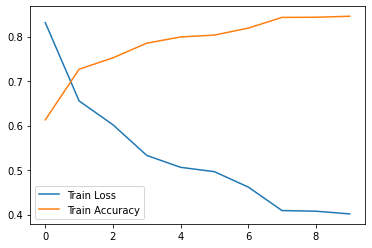

In [7]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='Train Loss')
plt.plot(list_acc_loss, label='Train Accuracy')
plt.legend()
plt.show()

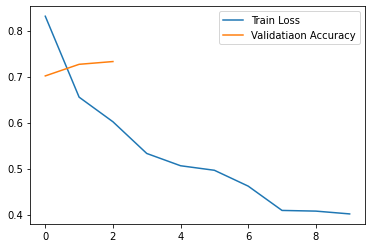

In [8]:
# train loss와 Validatiaon acc 출력
plt.plot(list_training_loss, label='Train Loss')
plt.plot(list_validation_acc_loss, label='Validatiaon Accuracy')
plt.legend()
plt.show()

In [9]:
### 전체모델 저장
#OUTPATH = '../model/distilbert/distilbert-model-0317-distillation-best-nli'

os.makedirs(OUTPATH, exist_ok=True)
#torch.save(model, OUTPATH + 'pytorch_model.bin') 
model.save_pretrained(OUTPATH)  # save_pretrained 로 저장하면 config.json, pytorch_model.bin 2개의 파일이 생성됨

# tokeinizer 파일 저장
VOCAB_PATH = OUTPATH
os.makedirs(VOCAB_PATH, exist_ok=True)
tokenizer.save_pretrained(VOCAB_PATH)

('../../../data11/model/NLI/mdistilbertV3.1-nli/tokenizer_config.json',
 '../../../data11/model/NLI/mdistilbertV3.1-nli/special_tokens_map.json',
 '../../../data11/model/NLI/mdistilbertV3.1-nli/vocab.txt',
 '../../../data11/model/NLI/mdistilbertV3.1-nli/added_tokens.json',
 '../../../data11/model/NLI/mdistilbertV3.1-nli/tokenizer.json')